# Import Libraries 

In [107]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.optimize import fminbound
from scipy.linalg import svd
from scipy.stats import trim_mean
import scipy.io
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import os
import functools

# Options

In [108]:
normalize_data = True
random_start = True
full_plot = False
early_subset = True
introduce_offset = True

imag_opt = False

# Initialize Parameters & Load Data

In [109]:
#Phased is a matrix of 64 TI trials. Each TI trial has 100 noise realizations with 2048 echos

cwd = os.getcwd()

file_oi = "real_phased_dataset" #imag_unphased_dataset    real_unphased_dataset   real_phased_dataset

raw = scipy.io.loadmat(f'{cwd}/{file_oi}.mat')
raw_complex = raw[file_oi]

with open(f'{cwd}/TI_phantom_nullExp.txt') as f:
    TI = f.readlines()

TI_num = [sub.replace("\n", "") for sub in TI]
TI_DATA = [1000*float(elem) for elem in TI_num]# ms/s conversion
assert(TI_DATA[0] < TI_DATA[-1])

TE_DATA = np.arange(1,2048.1,1)*0.4 #ms

sp = 2
ext = 256
if early_subset:
    raw_complex = raw_complex[sp-1::sp,:,:]
    TE_DATA = TE_DATA[sp-1::sp]
    raw_complex = raw_complex[:ext,:,:]
    TE_DATA = TE_DATA[:ext]

raw_real = np.real(raw_complex)
raw_imag = np.imag(raw_complex)

multi_start_obj = 20

if imag_opt:
    raw_data = raw_imag
else:
    raw_data = raw_real

noise_realizations = raw_data.shape[-1]
assert(len(TI_DATA) == raw_data.shape[1])

print(f"Raw Data has shape {raw_data.shape}")
print(f"TE values = [{TE_DATA[0]}, {TE_DATA[1]}, {TE_DATA[2]}, ..., {TE_DATA[-1]}]")

Raw Data has shape (256, 64, 99)
TE values = [0.8, 1.6, 2.4000000000000004, ..., 204.8]


In [110]:
#Upper will be referred to as the second point
T22 = 39.4 #39.4 +- 0.2 ms
T12 = 317 #317 +- 9 ms
c2 = 0.5

#Upper will be referred to as the first point
T21 = 31.3 #31.3 +- 0.1 ms
T11 = 103.6 #103.6 +- 4 ms
c1 = 0.5

true_params = [T11, T12, c1, c2, T21, T22]

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

# Define Functions

In [111]:
def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2


def get_func_bounds(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        lower_bound = (1, 1, 0, 0, 1, 1)
        upper_bound = (500, 500, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (1, 0, 1)
        upper_bound = (500, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 1, 1)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 1)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    # true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        p0 = true_params
            
    return p0


def det_normFactor(noisy_curve):

    lb = (0, 0, 0, 0)
    ub = (np.inf, np.inf, 150, 150)

    d_init = 0.5*noisy_curve[0]

    popt, _, _, _, _ = curve_fit(S_biX_4p, TE_DATA, noisy_curve, p0 = (d_init, d_init, 30, 50), bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output=True)

    return popt[0]+popt[1]

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

In [112]:
def calc_MSE(iteration_param_values, true_p):

    bias_values = np.mean(iteration_param_values - true_p, axis = 0)
    std_values = np.std(iteration_param_values, axis = 0)
    MSE_values = std_values**2 + bias_values

    return bias_values, std_values, MSE_values

def calc_SNR(noisy_curve):
    return noisy_curve[0]/np.mean(noisy_curve[-3:])


In [113]:
def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def estP_oneCurve(func, noisey_data, T_DATA):

    lb, ub = get_func_bounds(func)

    RSS = np.inf
    for iMS in range(multi_start_obj):
        init_p = set_p0(func, random = random_start)
        temp_popt, _, info, _, _ = curve_fit(func, T_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output = True)
        RSS_temp = np.sum(info['fvec']**2)
        if RSS_temp < RSS:
            RSS = RSS_temp
            popt = check_param_order(temp_popt)

    return popt, RSS


# Initial Visualization

(0.0, 300.0)

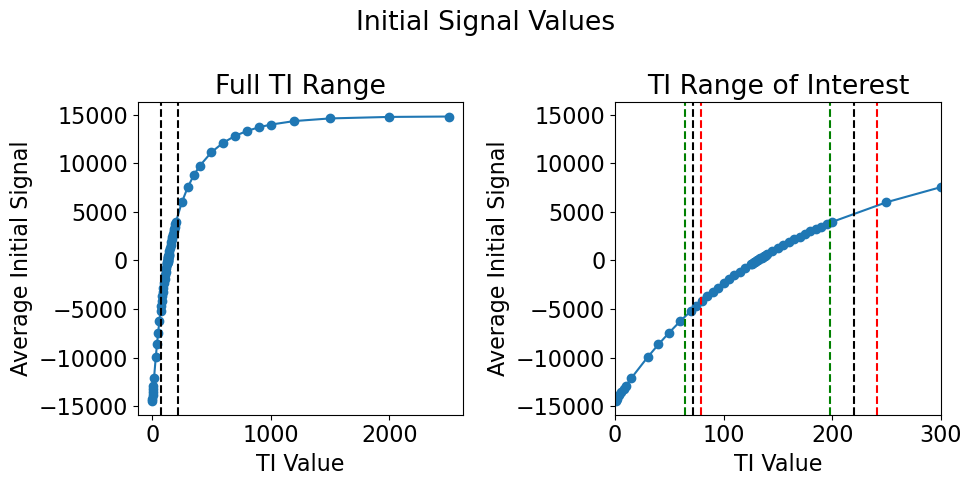

In [114]:
plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize = (10, 5), tight_layout=True)

fig.suptitle(f"Initial Signal Values")

ax[0].set_title("Full TI Range")
ax[0].plot(TI_DATA, np.mean(raw_data[0,:,:], axis = -1), marker = 'o')

ax[0].set_ylabel("Average Initial Signal")
ax[0].set_xlabel("TI Value")

ax[0].axvline(x = TI1star, ls = '--', color = 'k')
ax[0].axvline(x = TI2star, ls = '--', color = 'k')
# fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

ax[1].set_title("TI Range of Interest")
ax[1].plot(TI_DATA, np.mean(raw_data[0,:,:], axis = -1), marker = 'o')

ax[1].set_ylabel("Average Initial Signal")
ax[1].set_xlabel("TI Value")

ax[1].axvline(x = TI1star, ls = '--', color = 'k')
ax[1].axvline(x = TI2star, ls = '--', color = 'k')

ax[1].axvline(x = 0.9*TI1star, ls = '--', color = 'g')
ax[1].axvline(x = 0.9*TI2star, ls = '--', color = 'g')

ax[1].axvline(x = 1.1*TI1star, ls = '--', color = 'r')
ax[1].axvline(x = 1.1*TI2star, ls = '--', color = 'r')


ax[1].set_xlim([0,300])

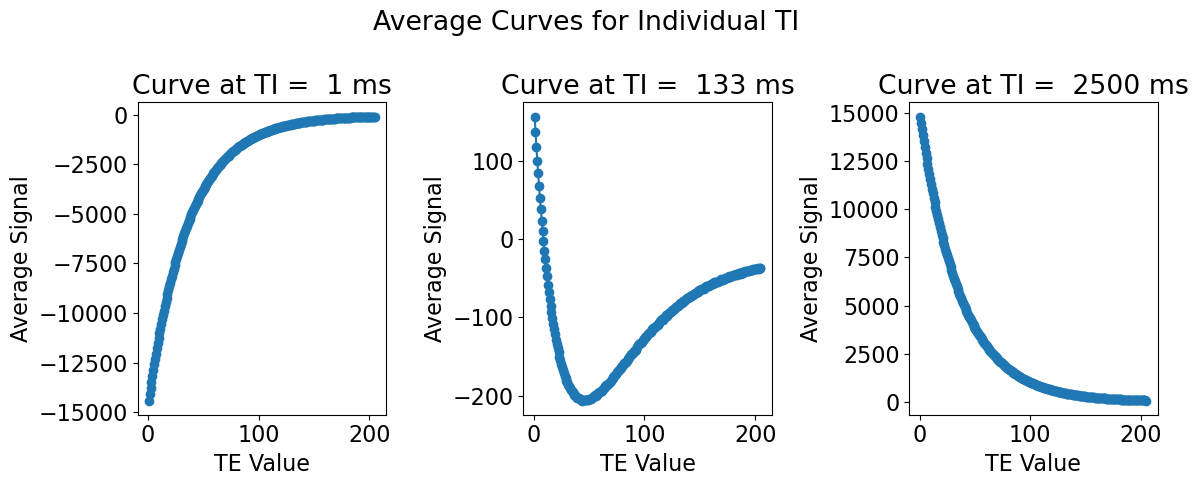

In [115]:
indices = [0,30,-1]

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,3, figsize = (12, 5), tight_layout=True)

fig.suptitle(f"Average Curves for Individual TI")

for i in range(len(indices)):
    index_oi = indices[i]
    ax[i].set_title(f"Curve at TI = {TI_DATA[index_oi]: .0f} ms")
    ax[i].plot(TE_DATA, np.mean(raw_data[:,index_oi,:], axis = -1), marker = 'o')

    ax[i].set_ylabel("Average Signal")
    ax[i].set_xlabel("TE Value")


# Checking Curve Shape with Model

Text(0.5, 0, 'TE Value')

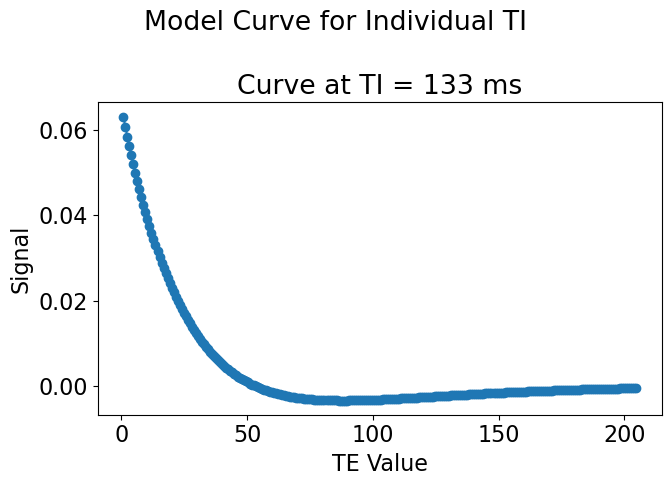

In [116]:
TI_funky = 133

data_temp = S_biX_6p(TE_DATA, *true_params, TI = TI_funky)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (7, 5), tight_layout=True)

fig.suptitle(f"Model Curve for Individual TI")

ax.set_title(f"Curve at TI = {TI_funky} ms")
ax.plot(TE_DATA, data_temp, marker = 'o')

ax.set_ylabel("Signal")
ax.set_xlabel("TE Value")

# SNR Calculation

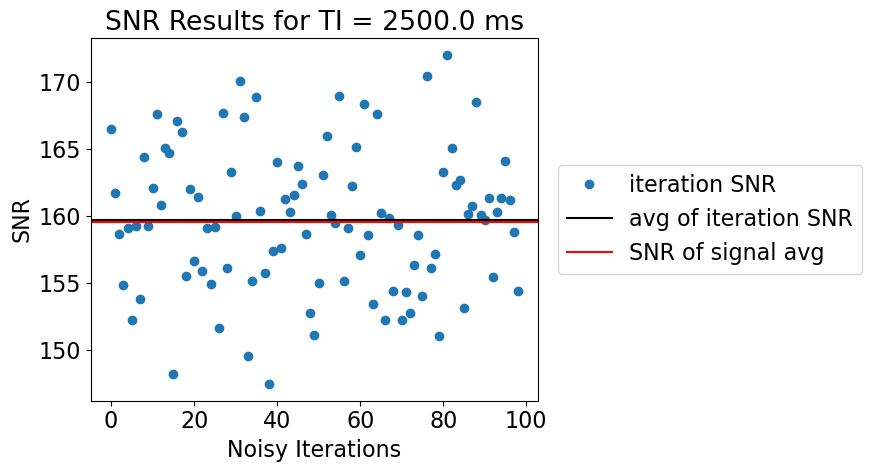

In [117]:
iterSNR = [calc_SNR(raw_data[:,-1,i]) for i in range(raw_data.shape[-1])]
avgSNR = calc_SNR(np.mean(raw_data[:,-1,:], axis = -1))

fig, ax = plt.subplots(1,1, figsize = (9, 5), tight_layout=True)

ax.set_title(f"SNR Results for TI = {TI_DATA[-1]} ms")
ax.plot(range(raw_data.shape[-1]), iterSNR, marker = 'o', ls = '', label = "iteration SNR")
ax.axhline(y = np.mean(iterSNR), color = 'k', label = 'avg of iteration SNR')
ax.axhline(y = avgSNR, color = 'r', label = 'SNR of signal avg')

ax.set_ylabel("SNR")
ax.set_xlabel("Noisy Iterations")

ax.legend(loc = 'center left', bbox_to_anchor = (1.02,0.5))

# Preprocessing

In [118]:
if normalize_data:
    norm_factor = det_normFactor(np.mean(raw_data[:,-1,:], axis = -1))
    normed_data = raw_data/norm_factor
    print(f"All data has been normalized by the normalization factor value of {norm_factor: 0.2f}")
else:
    print("No Normalization")
    normed_data = raw_data

All data has been normalized by the normalization factor value of  15090.20


# Estimating

In [119]:
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)
vecT = np.vstack((mTE.ravel(), mTI.ravel()))

param_iters_conven = np.zeros((raw_data.shape[-1],6))
param_iters_RSS = np.zeros((raw_data.shape[-1]))

avg_normed_data = np.mean(normed_data, axis = -1)

vecS = avg_normed_data.ravel()

param_avgSig_conven, RSS_avgSig_conven = estP_oneCurve(S_biX_6p_ravel, vecS, vecT)

print(f"Param Estimates")
[print(f'{elem:.2f}') for elem in param_avgSig_conven]
print(f"RSS = {RSS_avgSig_conven}")
print(f"Param Error")
[print(f'{elem:.2f}') for elem in (param_avgSig_conven-true_params)]

for i in trange(raw_data.shape[-1]):
    vecS = normed_data[:,:,i].ravel()
    temp_popt, temp_RSS = estP_oneCurve(S_biX_6p_ravel, vecS, vecT)

    param_iters_conven[i,:] = temp_popt
    param_iters_RSS[i] = temp_RSS

Param Estimates
78.14
500.00
0.10
0.48
6.01
7.41
RSS = 363.6743586927234
Param Error
-25.46
183.00
-0.40
-0.02
-25.29
-31.99


100%|██████████| 99/99 [07:43<00:00,  4.68s/it]


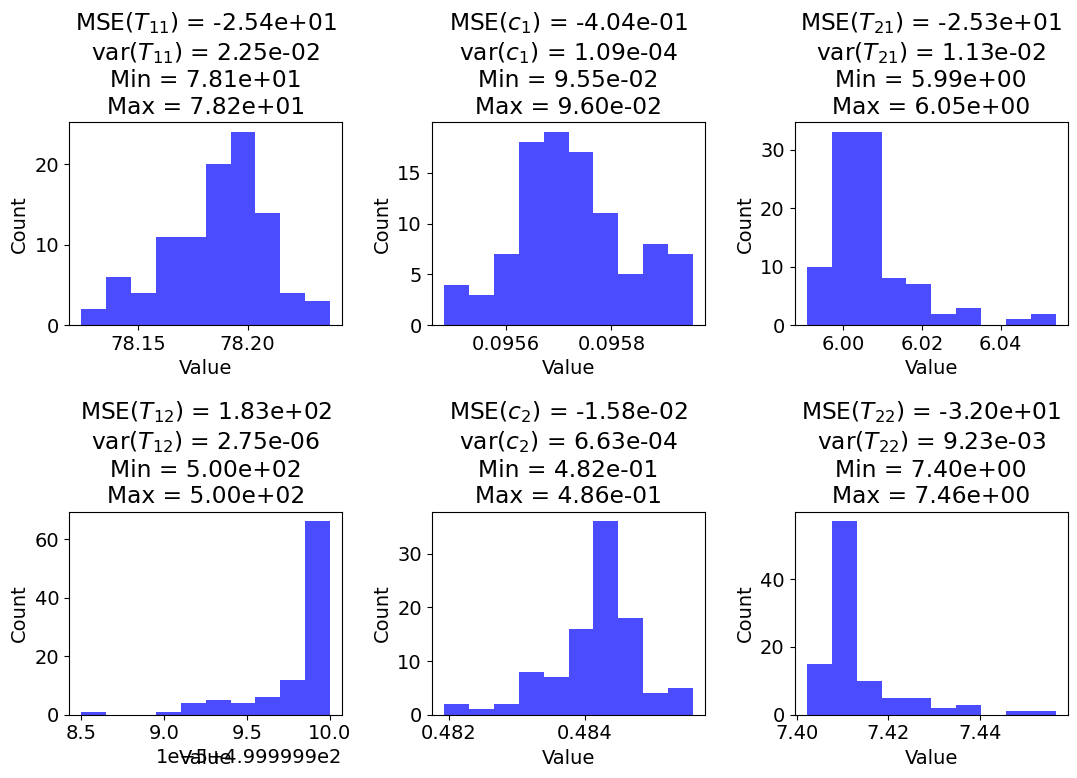

In [123]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(11, 8), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

MSEMat, varMat, sqBMat = calc_MSE(param_iters_conven, true_params)

for i in range(param_iters_conven.shape[-1]):

    # bin_array = np.arange(0, 1, 0.01)
    ax[i%2, i//2].hist(x=param_iters_conven[:,i], color='b', alpha = 0.7)
    # ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
    ax[i%2, i//2].set_xlabel('Value')
    ax[i%2, i//2].set_ylabel('Count')
    ax[i%2, i//2].set_title(f"MSE({ParamTitle_6p[i]}) = {MSEMat[i]:.2e}\nvar({ParamTitle_6p[i]}) = {varMat[i]:.2e}\nMin = {np.min(param_iters_conven[:,i]):.2e}\nMax = {np.max(param_iters_conven[:,i]):.2e}")

    ymin, ymax = ax[i%2, i//2].get_ylim()
    xmin, xmax = ax[i%2, i//2].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

# Visualizing Surface and Fits

(64, 256)
(256, 64)


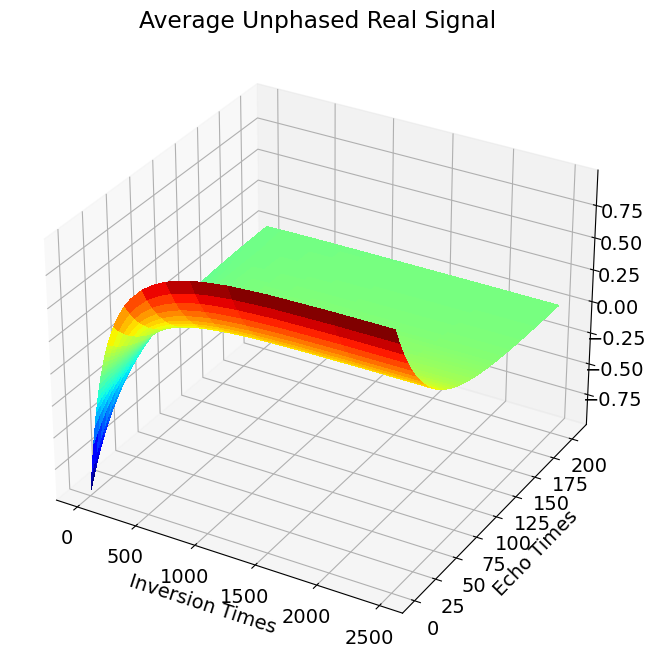

In [124]:
#### Actual Data Surface

print(mTI.shape)
print(avg_normed_data.shape)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, np.transpose(avg_normed_data), cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Average Unphased Real Signal')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

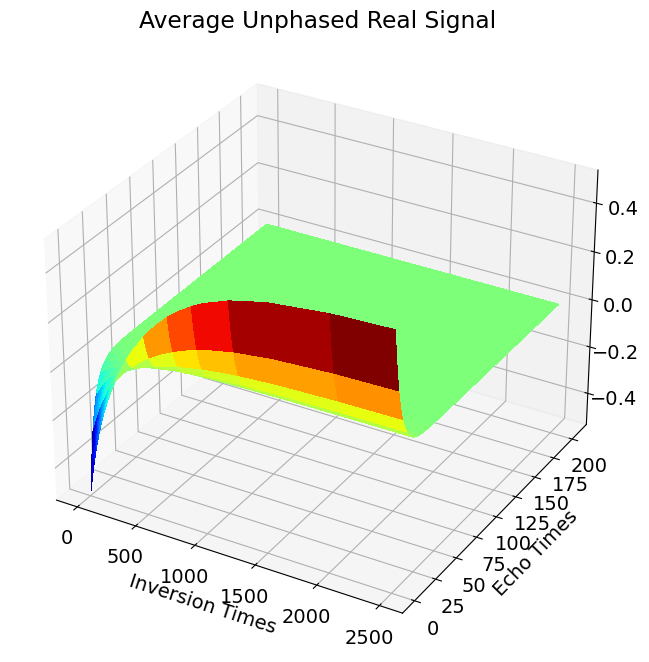

In [129]:
#### Actual Data Surface

recreated_sig = S_biX_6p(mTE, *param_avgSig_conven, TI = mTI)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, recreated_sig, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Average Unphased Real Signal')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

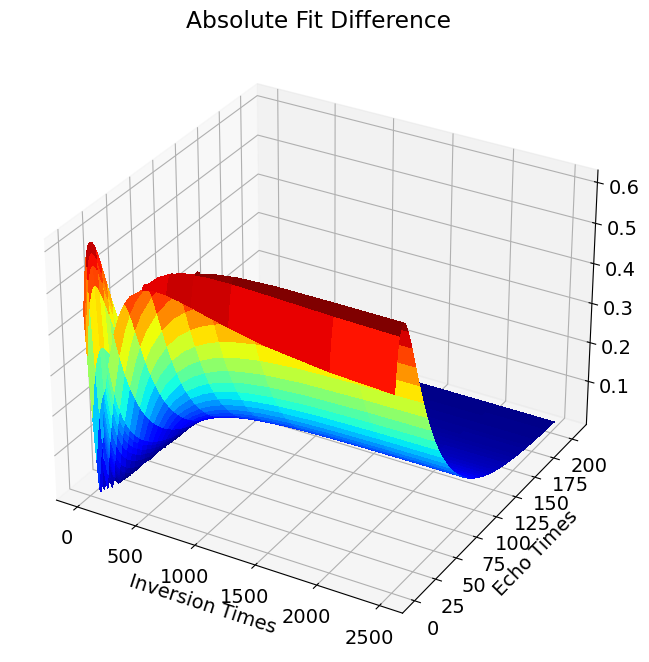

In [130]:
#### Actual Data Surface
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, np.abs(recreated_sig - np.transpose(avg_normed_data)), cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Absolute Fit Difference')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

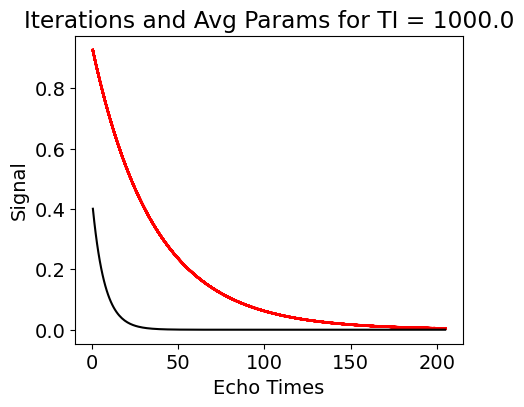

In [125]:
index_TI = -5

fig, ax = plt.subplots(1,1, figsize = (5,4))

TI_oi = TI_DATA[index_TI]

for i in range(normed_data.shape[-1]):
    ax.plot(TE_DATA, normed_data[:,index_TI, i], color = 'r')
    
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *param_avgSig_conven, TI = TI_oi), color = 'k')

ax.set_title(f'Iterations and Avg Params for TI = {TI_oi}')
ax.set_xlabel('Echo Times')
ax.set_ylabel('Signal')
plt.show()

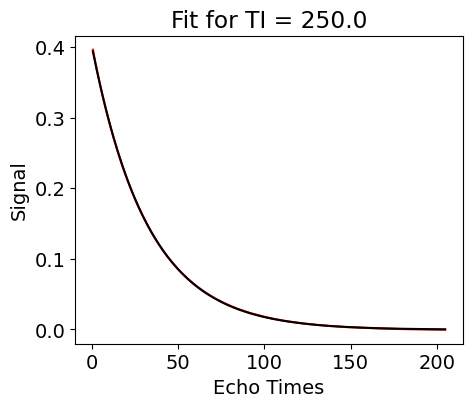

In [126]:
index_TI = 50

TI_oi = TI_DATA[index_TI]

lb, ub = get_func_bounds(S_biX_6p)

RSS = np.inf
for iMS in range(multi_start_obj):
    init_p = set_p0(S_biX_6p, random = random_start)
    temp_popt, _, info, _, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_DATA[index_TI]), TE_DATA, avg_normed_data[:,index_TI], p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output = True)
    RSS_temp = np.sum(info['fvec']**2)
    if RSS_temp < RSS:
        RSS = RSS_temp
        popt = check_param_order(temp_popt)

fig, ax = plt.subplots(1,1, figsize = (5,4))

TI_oi = TI_DATA[index_TI]

ax.plot(TE_DATA, avg_normed_data[:,index_TI], color = 'r')
    
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *popt, TI = TI_DATA[index_TI]), color = 'k')

ax.set_title(f'Fit for TI = {TI_oi}')
ax.set_xlabel('Echo Times')
ax.set_ylabel('Signal')
plt.show()

In [131]:
lb, ub = get_func_bounds(S_biX_6p)
popt_array = np.zeros((len(TI_DATA), 6))
RSS_array = np.zeros(len(TI_DATA))

for iTI in trange(len(TI_DATA)):

    RSS = np.inf
    for iMS in range(multi_start_obj):
        init_p = set_p0(S_biX_6p, random = random_start)
        temp_popt, _, info, _, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_DATA[iTI]), TE_DATA, avg_normed_data[:,iTI], p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 4000, full_output = True)
        RSS_temp = np.sum(info['fvec']**2)
        if RSS_temp < RSS:
            RSS = RSS_temp
            popt = check_param_order(temp_popt)

    popt_array[iTI,:] = popt
    RSS_array[iTI] = RSS



100%|██████████| 64/64 [00:36<00:00,  1.73it/s]


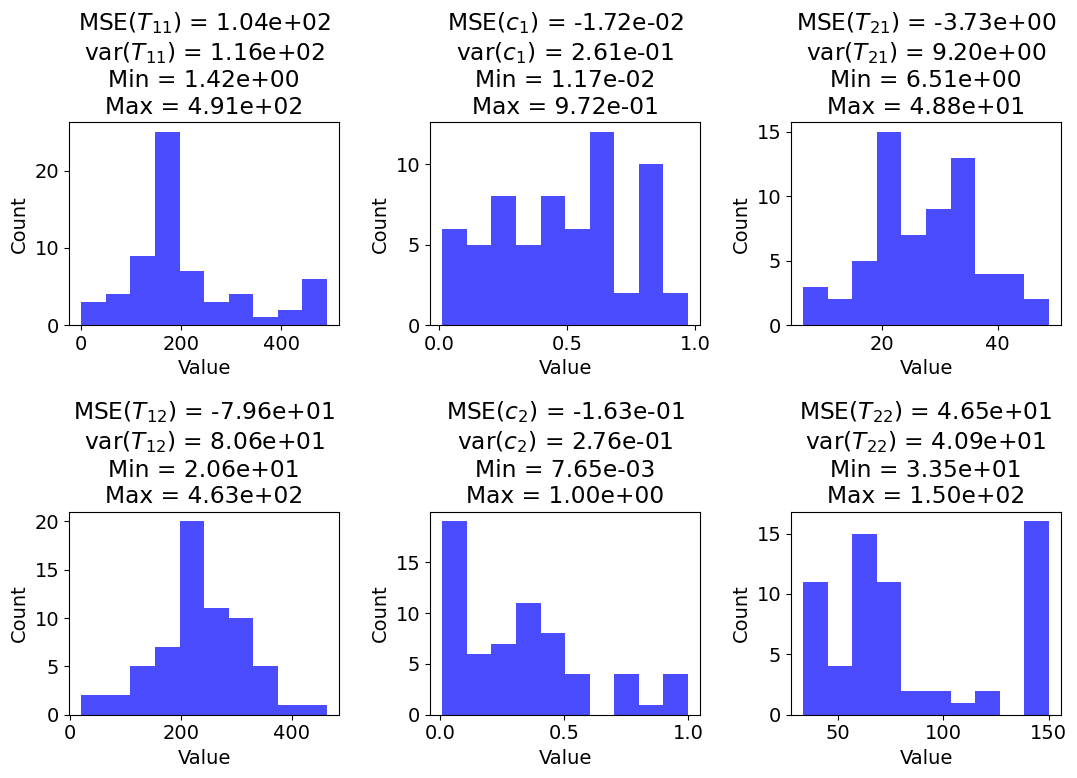

In [134]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(11, 8), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

MSEMat, varMat, sqBMat = calc_MSE(popt_array, true_params)

for i in range(popt_array.shape[-1]):

    # bin_array = np.arange(0, 1, 0.01)
    ax[i%2, i//2].hist(x=popt_array[:,i], color='b', alpha = 0.7)
    # ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
    ax[i%2, i//2].set_xlabel('Value')
    ax[i%2, i//2].set_ylabel('Count')
    ax[i%2, i//2].set_title(f"MSE({ParamTitle_6p[i]}) = {MSEMat[i]:.2e}\nvar({ParamTitle_6p[i]}) = {varMat[i]:.2e}\nMin = {np.min(popt_array[:,i]):.2e}\nMax = {np.max(popt_array[:,i]):.2e}")

    ymin, ymax = ax[i%2, i//2].get_ylim()
    xmin, xmax = ax[i%2, i//2].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

Text(0, 0.5, 'Count')

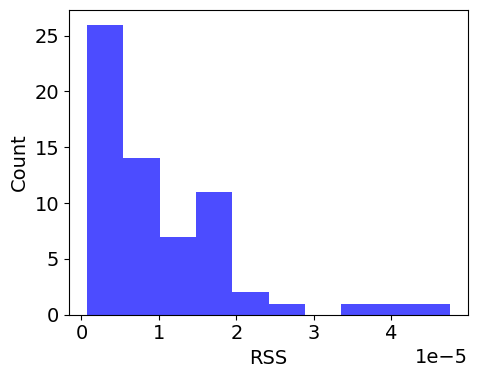

In [135]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(1,1, figsize=(5, 4), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

ax.hist(x=RSS_array, color='b', alpha = 0.7)
# ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
ax.set_xlabel('RSS')
ax.set_ylabel('Count')